In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd
from shapely.geometry import point, polygon
import descartes
from IPython.core.display import HTML



Load the Data

In [7]:
#loading House_Data

df_base = pd.read_csv('kc_house_data.csv')
df_base.reset_index()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


Data Clean Step1

In [8]:
#Data Cleaning - Removing 'id' duplicates keeping the most recent selling date
 
df_base = df_base.sort_values('date').drop_duplicates('id', keep='first')
df_base.sort_values('id', ascending = True, inplace = True)
df_base.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,0.0,0.0,...,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
6729,1200019,5/8/2014,647500.0,4,1.75,2060,26036,1.0,NaN,0.0,...,8,1160,900.0,1947,0.0,98166,47.4444,-122.351,2590,21891
8404,1200021,8/11/2014,400000.0,3,1.00,1460,43000,1.0,0.0,0.0,...,7,1460,0.0,1952,0.0,98166,47.4434,-122.347,2250,20023
8800,2800031,4/1/2015,235000.0,3,1.00,1430,7599,1.5,0.0,0.0,...,6,1010,420.0,1930,0.0,98168,47.4783,-122.265,1290,10320
3553,3600057,3/19/2015,402500.0,4,2.00,1650,3504,1.0,0.0,0.0,...,7,760,890.0,1951,2013.0,98144,47.5803,-122.294,1480,3504


In [9]:
#Checking for Nulls in the DataSet

df_base.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2355
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3812
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Data Clean Step 2

In [10]:
#Null approach:

#Waterfront - removing waterfront column as it is uncorrelated to the price variable. 
#Additionally, Seattle is surounded by bodies of water where water views are not a differentiator. 

df_base = df_base.drop(['waterfront'], axis =1)


In [11]:
#View - for the number of viewings we make an assumption that no viewings (0 value) have been made where the value is null.
#The number of nulls in view is unsignificant in the dataset (<1%)

#yr_renovated - we make the assumption here that no renovation has occured for null values in yr_renovated. 

df_base.fillna(0, inplace = True)

df_base.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,0.0,3,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
6729,1200019,5/8/2014,647500.0,4,1.75,2060,26036,1.0,0.0,4,8,1160,900.0,1947,0.0,98166,47.4444,-122.351,2590,21891
8404,1200021,8/11/2014,400000.0,3,1.00,1460,43000,1.0,0.0,3,7,1460,0.0,1952,0.0,98166,47.4434,-122.347,2250,20023
8800,2800031,4/1/2015,235000.0,3,1.00,1430,7599,1.5,0.0,4,6,1010,420.0,1930,0.0,98168,47.4783,-122.265,1290,10320
3553,3600057,3/19/2015,402500.0,4,2.00,1650,3504,1.0,0.0,3,7,760,890.0,1951,2013.0,98144,47.5803,-122.294,1480,3504


In [12]:
#Re-checking for nulls

df_base.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [13]:
######## REVIEW 

df_base ['price_per_sqft_living'] = round(df_base ['price'] / df_base ['sqft_living'])
df_base['renovation'] = np.where(df_base['yr_renovated']>0, 'Yes', 'No')



Data Clean Step 3

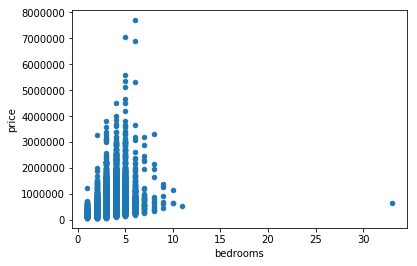

In [14]:
#Sorting by bedroom - identify outlier
df_base = df_base.sort_values('bedrooms', ascending = False)

#plotting bedrooms by Price 
df_base.plot(kind = 'scatter', x ='bedrooms', y = 'price')


In [15]:
#Drop bedroom outlier with 33 rooms 

df_base.drop(df_base.loc[df_base['bedrooms']== 33].index)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,renovation
8748,1773100755,8/21/2014,520000.0,11,3.00,3000,4960,2.0,0.0,3,...,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,173.0,Yes
15147,5566100170,10/29/2014,650000.0,10,2.00,3610,11914,2.0,0.0,4,...,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914,180.0,No
13301,627300145,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,2.0,3,...,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400,251.0,No
19239,8812401450,12/29/2014,660000.0,10,3.00,2920,3745,2.0,0.0,4,...,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745,226.0,No
6073,9822700190,8/8/2014,1280000.0,9,4.50,3650,5000,2.0,0.0,3,...,1120.0,1915,2010.0,98105,47.6604,-122.289,2510,5000,351.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21310,6003000851,5/22/2014,353000.0,1,1.00,550,1279,2.0,0.0,3,...,0.0,2008,0.0,98122,47.6160,-122.314,1460,1385,642.0,No
17404,2922703235,11/19/2014,290000.0,1,1.00,550,5700,1.0,0.0,2,...,0.0,1916,0.0,98117,47.6846,-122.366,1100,4560,527.0,No
17970,3448001975,5/4/2015,351000.0,1,0.75,930,6600,1.0,0.0,3,...,0.0,1924,0.0,98125,47.7127,-122.296,1590,6600,377.0,No
8438,724069023,4/14/2015,1250000.0,1,1.25,1810,5070,1.5,4.0,4,...,580.0,1967,0.0,98075,47.5814,-122.081,2280,5070,691.0,No


In [16]:
df_base.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,renovation
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,3,...,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113,129.0,No
1235,4140900140,5/27/2014,438000.0,3,1.75,1650,12940,1.0,0.0,4,...,0.0,1961,0.0,98028,47.7629,-122.268,2830,12600,265.0,No
19265,3658700395,4/9/2015,628000.0,4,1.75,1940,3060,1.0,0.0,4,...,940.0,1911,0.0,98115,47.6786,-122.317,1320,3060,324.0,No
18625,4443801340,10/6/2014,480000.0,3,1.75,1680,2552,1.0,0.0,4,...,840.0,1952,0.0,98117,47.6848,-122.391,1220,3880,286.0,No
2841,7199360090,3/20/2015,478000.0,3,1.00,1440,7107,1.0,0.0,4,...,440.0,1980,0.0,98052,47.6968,-122.124,1540,7140,332.0,No
3209,3959400855,8/20/2014,525000.0,4,2.75,2470,7200,1.0,0.0,5,...,1120.0,1940,0.0,98108,47.5631,-122.317,1500,6000,213.0,No
20379,886000090,3/2/2015,395000.0,2,1.00,700,7457,1.0,0.0,3,...,0.0,1943,0.0,98108,47.5348,-122.295,1500,7130,564.0,No
14390,7987401010,7/3/2014,633000.0,4,2.50,2360,10000,1.0,3.0,3,...,380.0,1977,0.0,98126,47.5730,-122.374,2480,5000,268.0,No
2590,8078460810,12/10/2014,620000.0,4,2.50,2580,7465,2.0,0.0,3,...,0.0,1993,0.0,98074,47.6319,-122.022,2350,7596,240.0,No
6142,2610100020,4/8/2015,290000.0,4,1.00,1010,7200,1.5,0.0,3,...,0.0,1947,0.0,98155,47.7420,-122.325,1360,7200,287.0,No


In [17]:
df_base.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price_per_sqft_living', 'renovation'],
      dtype='object')

In [18]:
cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'sqft_living15', 'view', 'condition', 'grade']

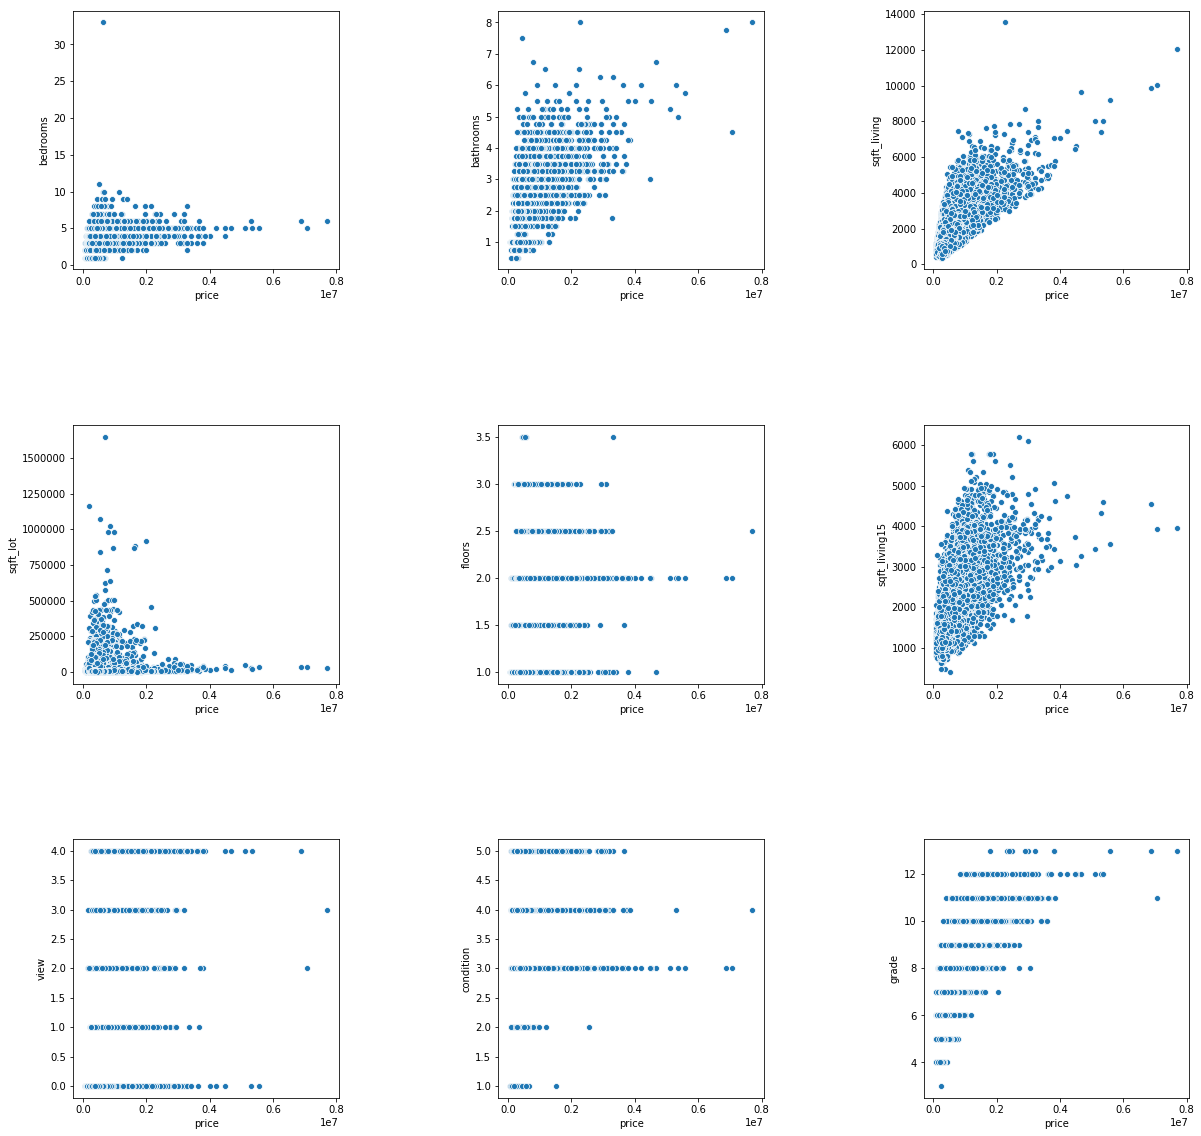

In [19]:
#Data Vizualization for outlier identification 

plt.figure(figsize=(20,20))

for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x="price", y=col, data= df_base)
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    
   


In [20]:
#sqft living outlier removal using standard deviation


#Create column with std deviation for sqft_living variable 
df_base['sqft_sd'] = df_base['sqft_living'].std()

#Create column with how many std deviation away from the mean each value for sqft living is
df_base['outlier_sqft'] = (df_base ['sqft_living'] - df_base['sqft_living'].mean())/df_base['sqft_sd']

df_base = df_base [df_base ['outlier_sqft'] <2] #keep values smaller than 2 std deviation of mean
df_base = df_base [df_base ['outlier_sqft'] > -2] #keep values greater than -2 std deviation of mean 

df_base.sort_values('outlier_sqft', ascending = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,renovation,sqft_sd,outlier_sqft
5020,3362401611,3/25/2015,1170000.0,4,3.75,3920,4500,3.0,0.0,3,...,0.0,98103,47.6805,-122.346,2040,3000,298.0,No,918.808412,1.999184
7306,4131900066,8/25/2014,3100000.0,3,3.00,3920,13085,2.0,4.0,4,...,0.0,98040,47.5716,-122.204,3450,13287,791.0,No,918.808412,1.999184
17457,2205700470,1/22/2015,650500.0,5,4.25,3920,11412,2.0,0.0,3,...,2005.0,98006,47.5766,-122.151,1400,9750,166.0,Yes,918.808412,1.999184
16215,7853301660,2/23/2015,710000.0,5,3.25,3920,8572,2.0,0.0,3,...,0.0,98065,47.5427,-121.887,3335,7258,181.0,No,918.808412,1.999184
10963,3295610200,6/25/2014,770000.0,4,2.50,3920,12415,2.0,0.0,3,...,0.0,98075,47.5658,-122.032,3639,12805,196.0,No,918.808412,1.999184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14452,7549801385,6/12/2014,280000.0,1,0.75,420,6720,1.0,0.0,3,...,0.0,98108,47.5520,-122.311,1420,6720,667.0,No,918.808412,-1.810097
8614,6303400395,1/30/2015,325000.0,1,0.75,410,8636,1.0,0.0,2,...,0.0,98146,47.5077,-122.357,1190,8636,793.0,No,918.808412,-1.820981
21316,9266700190,5/11/2015,245000.0,1,1.00,390,2000,1.0,0.0,4,...,0.0,98103,47.6938,-122.347,1340,5100,628.0,No,918.808412,-1.842748
860,1723049033,6/20/2014,245000.0,1,0.75,380,15000,1.0,0.0,3,...,0.0,98168,47.4810,-122.323,1170,15000,645.0,No,918.808412,-1.853632


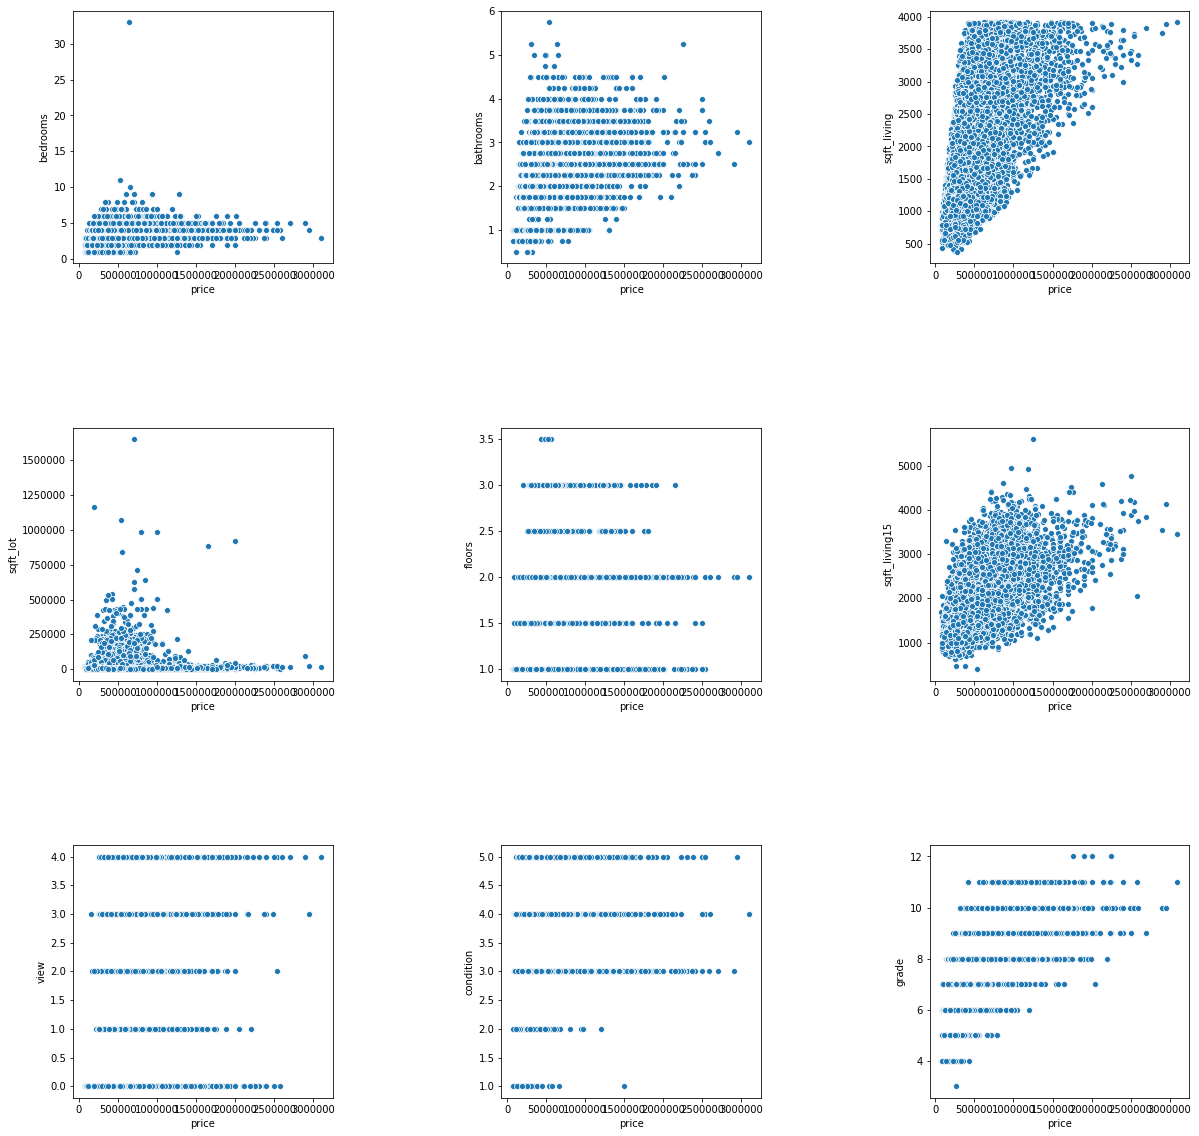

In [21]:
plt.figure(figsize=(20,20))

for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x="price", y=col, data= df_base)
    plt.subplots_adjust(wspace=0.65, hspace=0.65)


In [22]:
#Creation of new column for neighbors vs sqft living

df_base['sqft_vs_nghbrs'] = np.where(df_base['sqft_living'] > df_base['sqft_living15'], 1, 0)

df_base.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,renovation,sqft_sd,outlier_sqft,sqft_vs_nghbrs
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,5,...,98103,47.6878,-122.331,1330,4700,395.0,No,918.808412,-0.504058,1
8748,1773100755,8/21/2014,520000.0,11,3.00,3000,4960,2.0,0.0,3,...,98106,47.5560,-122.363,1420,4960,173.0,Yes,918.808412,0.997887,1
15147,5566100170,10/29/2014,650000.0,10,2.00,3610,11914,2.0,0.0,4,...,98006,47.5705,-122.175,2040,11914,180.0,No,918.808412,1.661791,1
19239,8812401450,12/29/2014,660000.0,10,3.00,2920,3745,2.0,0.0,4,...,98105,47.6635,-122.320,1810,3745,226.0,No,918.808412,0.910818,1
6073,9822700190,8/8/2014,1280000.0,9,4.50,3650,5000,2.0,0.0,3,...,98105,47.6604,-122.289,2510,5000,351.0,Yes,918.808412,1.705325,1


In [23]:
#remove bathrooms outliers

df_base.sort_values('price', ascending = False, inplace = True)



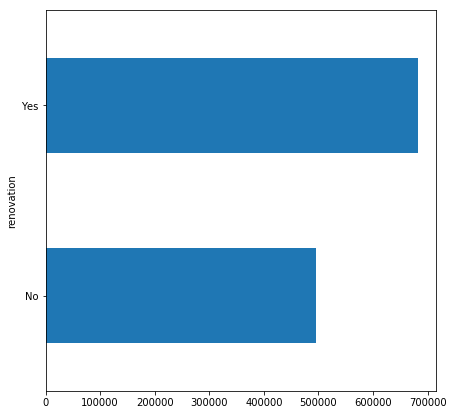

In [24]:
#Check renovation impact on Price 

df_base.groupby('renovation')['price'].mean().plot(kind = 'barh', x = 'price', figsize = (7,7))

In [25]:
#Setting up variables for statistical analysis 

X = df_base [['sqft_living', 'grade']]
Y = df_base ['price']
Z = df_base ['sqft_vs_nghbrs']


In [26]:
# Setting up the LEARNER
X = sm.add_constant(X)
model_sm = sm.OLS(Y,X)

#Learning
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))

R2 = 0.44
const         -489830.2525
sqft_living       122.3514
grade           99315.4976
dtype: float64


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [27]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     8214.
Date:                Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:15:04   Log-Likelihood:            -2.8012e+05
No. Observations:               20560   AIC:                         5.602e+05
Df Residuals:                   20557   BIC:                         5.603e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.898e+05   1.12e+04    -43.597      0.000   -5.12e+05   -4.68e+05
sqft_living   122.3514      2.680     45.650      0.000     117.098     127.605
grade        9.932e+04   1883.066     52.741      0.000    9.56e+04    1.03e+05
==============================================================================
Omnibus:                     9051.904   Durbin-Watson:                   0.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80281.423
Skew:                           1.897   Prob(JB):                         0.00
Kurtosis:                      11.906   Cond. No.                     1.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
df_base_2 = df_base.drop(['id','yr_built', 'yr_renovated','zipcode', 'lat','long','bathrooms', 'outlier_sqft', 'sqft_sd', 'sqft_vs_nghbrs'], axis = 1)
corr1 = df_base_2.corr().round(2)
corr1.sort_values('grade', ascending = False)

,price,bedrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_living15,sqft_lot15,price_per_sqft_living
grade,0.62,0.31,0.71,0.07,0.45,0.18,-0.15,1.00,0.70,0.66,0.08,0.08
sqft_living,0.61,0.58,1.00,0.12,0.34,0.20,-0.05,0.71,0.84,0.73,0.14,-0.20
sqft_above,0.50,0.46,0.84,0.13,0.53,0.09,-0.16,0.70,1.00,0.70,0.15,-0.18
sqft_living15,0.55,0.36,0.73,0.13,0.25,0.23,-0.09,0.66,0.70,1.00,0.17,-0.01
price,1.00,0.27,0.61,0.06,0.24,0.35,0.06,0.62,0.50,0.55,0.05,0.59
floors,0.24,0.15,0.34,-0.03,1.00,-0.00,-0.27,0.45,0.53,0.25,-0.03,-0.01
bedrooms,0.27,1.00,0.58,0.01,0.15,0.04,0.04,0.31,0.46,0.36,0.01,-0.24
view,0.35,0.04,0.20,0.07,-0.00,1.00,0.05,0.18,0.09,0.23,0.07,0.20
sqft_lot15,0.05,0.01,0.14,0.70,-0.03,0.07,0.00,0.08,0.15,0.17,1.00,-0.06
price_per_sqft_living,0.59,-0.24,-0.20,-0.03,-0.01,0.20,0.10,0.08,-0.18,-0.01,-0.06,1.00


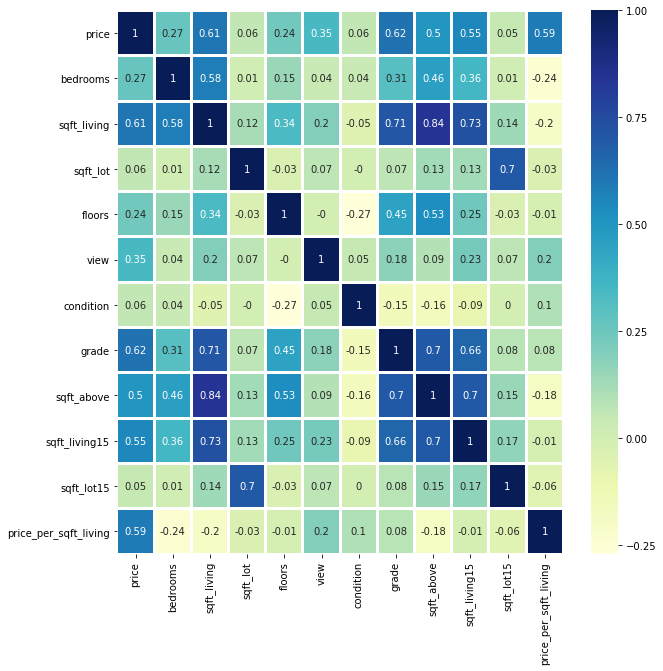

In [29]:
#Updated & Simplified correlation heatmap

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data = corr1, annot = True, annot_kws = {"size": 10}, linewidth = 2, cmap="YlGnBu")


In [30]:
# Questions for Dave:


#How to approach variable selection?
#Can we use standard deviation to exclude outliers where relevant? 
#Or is there a different method we are expected to use?
#Is it ok to keep to two or three variables for the first project?
#Comment on what we've done so far 


#watch for multicollinearity - (you don't want high correlation between variables)
#condition number to check 

#Standardized vs unstandardized beta 

#standardize for prediction 
#unstandardize for contribution of variable

In [31]:
df_base.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,sqft_sd,outlier_sqft,sqft_vs_nghbrs
count,2.056000e+04,2.056000e+04,20560.000000,20560.000000,20560.000000,2.056000e+04,20560.000000,20560.000000,20560.000000,20560.000000,...,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,2.056000e+04,20560.000000,20560.000000
mean,4.603330e+09,5.018869e+05,3.329815,2.055107,1972.627091,1.402947e+04,1.478526,0.201605,3.416391,7.555350,...,67.462160,98078.773784,47.558961,-122.216424,1929.594504,12055.916488,262.558998,9.188084e+02,-0.120270,0.437208
std,2.877162e+09,2.681299e+05,0.899993,0.697992,733.578585,3.840665e+04,0.538253,0.707102,0.652319,1.044117,...,360.692348,53.532179,0.139839,0.140546,610.167836,24856.572335,107.993581,2.636462e-10,0.798402,0.496054
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,...,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,88.000000,9.188084e+02,-1.864516,0.000000
25%,2.130702e+09,3.190000e+05,3.000000,1.500000,1410.000000,5.000000e+03,1.000000,0.000000,3.000000,7.000000,...,0.000000,98033.000000,47.465900,-122.331000,1470.000000,5026.750000,182.000000,9.188084e+02,-0.732615,0.000000
50%,3.905090e+09,4.402000e+05,3.000000,2.250000,1870.000000,7.500000e+03,1.000000,0.000000,3.000000,7.000000,...,0.000000,98070.000000,47.570600,-122.237000,1810.000000,7518.000000,244.000000,9.188084e+02,-0.231966,0.000000
75%,7.338001e+09,6.150000e+05,4.000000,2.500000,2460.000000,1.027775e+04,2.000000,0.000000,4.000000,8.000000,...,0.000000,98118.000000,47.679000,-122.128000,2300.000000,9866.500000,317.000000,9.188084e+02,0.410170,1.000000
max,9.900000e+09,3.100000e+06,33.000000,5.750000,3920.000000,1.651359e+06,3.500000,4.000000,5.000000,12.000000,...,2015.000000,98199.000000,47.777600,-121.315000,5600.000000,560617.000000,810.000000,9.188084e+02,1.999184,1.000000


In [32]:
seattle_map = gpd.read_file('Seattle_Streets/Street_Network_Database_SND.shp')



In [33]:
# geometry = [point(x, y) for xy in zip(df_base['lat'], df_base['long'])]

gdf = gpd.GeoDataFrame(
    df_base,geometry=gpd.points_from_xy(df_base.long, df_base.lat))
gdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,renovation,sqft_sd,outlier_sqft,sqft_vs_nghbrs,geometry
7306,4131900066,8/25/2014,3100000.0,3,3.00,3920,13085,2.0,4.0,4,...,47.5716,-122.204,3450,13287,791.0,No,918.808412,1.999184,1,POINT (-122.20400 47.57160)
18541,6613000930,9/2/2014,2950000.0,4,3.25,3890,25470,2.0,3.0,5,...,47.6608,-122.269,4140,19281,758.0,No,918.808412,1.966533,0,POINT (-122.26900 47.66080)
6396,2624049091,3/13/2015,2900000.0,5,2.50,3750,91681,2.0,4.0,3,...,47.5379,-122.264,3540,24293,773.0,No,918.808412,1.814162,1,POINT (-122.26400 47.53790)
6765,5442300807,6/24/2014,2700000.0,5,2.75,3831,13800,2.0,4.0,3,...,47.5919,-122.251,3850,36563,705.0,Yes,918.808412,1.902320,0,POINT (-122.25100 47.59190)
14808,3623500408,3/30/2015,2600000.0,3,3.00,3410,16015,2.0,4.0,4,...,47.5721,-122.239,3760,16572,762.0,No,918.808412,1.444118,0,POINT (-122.23900 47.57210)


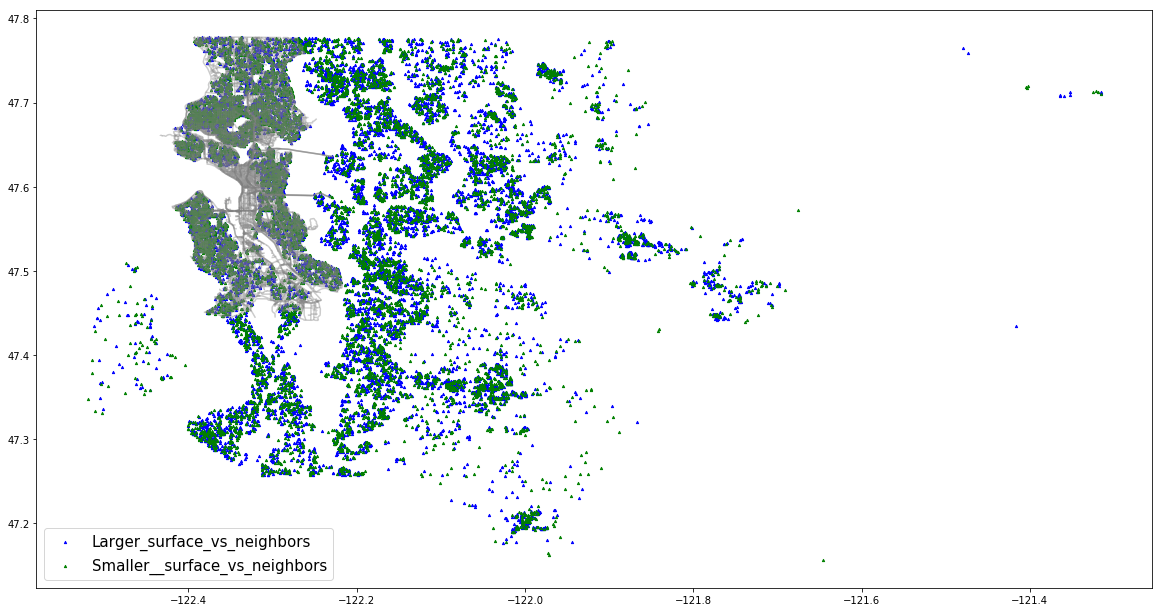

In [40]:
fig, ax = plt.subplots(figsize = (20, 20))
seattle_map.plot(ax = ax, alpha =0.4, color = 'grey')

gdf[gdf['sqft_vs_nghbrs'] == 0].plot(ax = ax, markersize = 5, color ='blue', marker = '^', label = 'Larger_surface_vs_neighbors')

gdf[gdf['sqft_vs_nghbrs'] == 1].plot(ax = ax, markersize = 5, color ='green', marker = '^', label = 'Smaller__surface_vs_neighbors')

plt.legend(prop = {'size': 15})

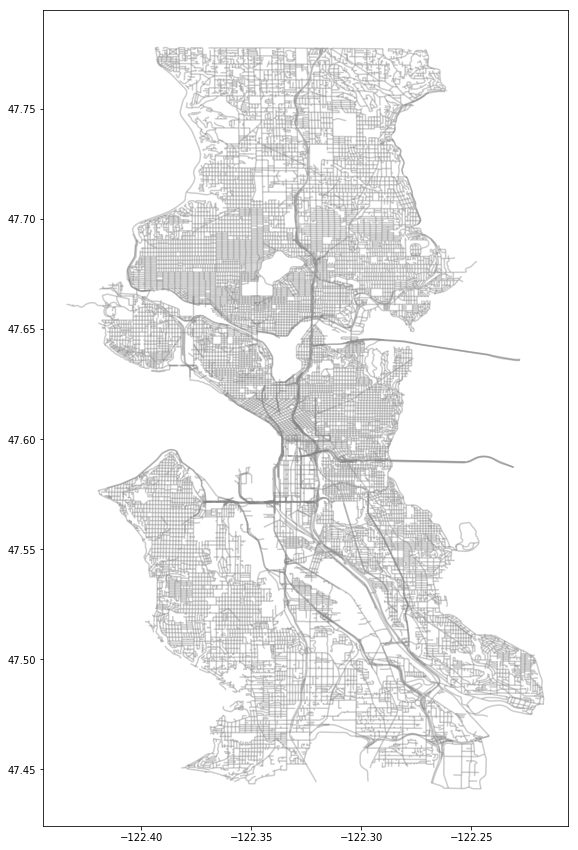

In [35]:
fig, ax = plt.subplots(figsize = (15,15))
seattle_map.plot(ax = ax, alpha =0.4, color = 'grey')

In [61]:
df_zip = df_base.groupby('zipcode')
df_zip = df_zip.apply(lambda x: x.sample(n=15, replace = True))

In [65]:
df_zip.shape

(1050, 26)

In [66]:
df_zip.head()

id       date     price  bedrooms  bathrooms  \
zipcode                                                               
98001   14586  3422049158  7/11/2014  246000.0         3       1.75   
        20129  9264450460   6/3/2014  309000.0         5       2.75   
        5756   6181400470  1/27/2015  215000.0         4       2.50   
        18708  8856003525  3/23/2015  183500.0         3       1.00   
        14487  3353402390   5/1/2015  171500.0         3       1.00   

               sqft_living  sqft_lot  floors  view  condition  ...      lat  \
zipcode                                                        ...            
98001   14586         1440     11325     1.0   0.0          4  ...  47.3503   
        20129         2481      4045     2.0   0.0          3  ...  47.2602   
        5756          2130      4496     2.0   0.0          3  ...  47.3041   
        18708         1010      7520     1.0   0.0          4  ...  47.2699   
        14487         1150      6480     1.5   0.0          4  ...  47.2642   

                  long sqft_living15  sqft_lot15  price_per_sqft_living  \
zipcode                                                                   
98001   14586 -122.279          1440       20000                  171.0   
        20129 -122.284          2363        4175                  125.0   
        5756  -122.280          3220        5400                  101.0   
        18708 -122.255          1370        8469                  182.0   
        14487 -122.258          1100        7300                  149.0   

               renovation     sqft_sd  outlier_sqft  sqft_vs_nghbrs  \
zipcode                                                               
98001   14586          No  918.808412     -0.699964               0   
        20129          No  918.808412      0.433025               1   
        5756           No  918.808412      0.051009               0   
        18708          No  918.808412     -1.167961               0   
        14487          No  918.808412     -1.015590               1   

                                  geometry  
zipcode                                     
98001   14586  POINT (-122.27900 47.35030)  
        20129  POINT (-122.28400 47.26020)  
        5756   POINT (-122.28000 47.30410)  
        18708  POINT (-122.25500 47.26990)  
        14487  POINT (-122.25800 47.26420)  

[5 rows x 26 columns]

In [67]:
df_zip_2 = df_zip.drop(['id','yr_built', 'yr_renovated','zipcode', 'lat','long','bathrooms', 'outlier_sqft', 'sqft_sd', 'sqft_vs_nghbrs'], axis = 1)
corr1 = df_zip_2.corr().round(2)
corr1.sort_values('grade', ascending = False)

,price,bedrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_living15,sqft_lot15,price_per_sqft_living
grade,0.60,0.31,0.72,0.06,0.46,0.15,-0.11,1.00,0.71,0.68,0.05,0.10
sqft_living,0.59,0.57,1.00,0.09,0.36,0.15,-0.03,0.72,0.84,0.74,0.09,-0.16
sqft_above,0.48,0.46,0.84,0.13,0.56,0.05,-0.16,0.71,1.00,0.71,0.13,-0.14
sqft_living15,0.58,0.32,0.74,0.12,0.28,0.19,-0.09,0.68,0.71,1.00,0.15,0.07
price,1.00,0.25,0.59,0.07,0.23,0.29,0.07,0.60,0.48,0.58,0.03,0.63
floors,0.23,0.13,0.36,0.03,1.00,0.02,-0.24,0.46,0.56,0.28,-0.01,-0.01
bedrooms,0.25,1.00,0.57,-0.02,0.13,-0.05,0.04,0.31,0.46,0.32,-0.04,-0.22
view,0.29,-0.05,0.15,0.04,0.02,1.00,0.06,0.15,0.05,0.19,0.03,0.19
price_per_sqft_living,0.63,-0.22,-0.16,0.01,-0.01,0.19,0.10,0.10,-0.14,0.07,-0.03,1.00
sqft_lot,0.07,-0.02,0.09,1.00,0.03,0.04,-0.05,0.06,0.13,0.12,0.71,0.01


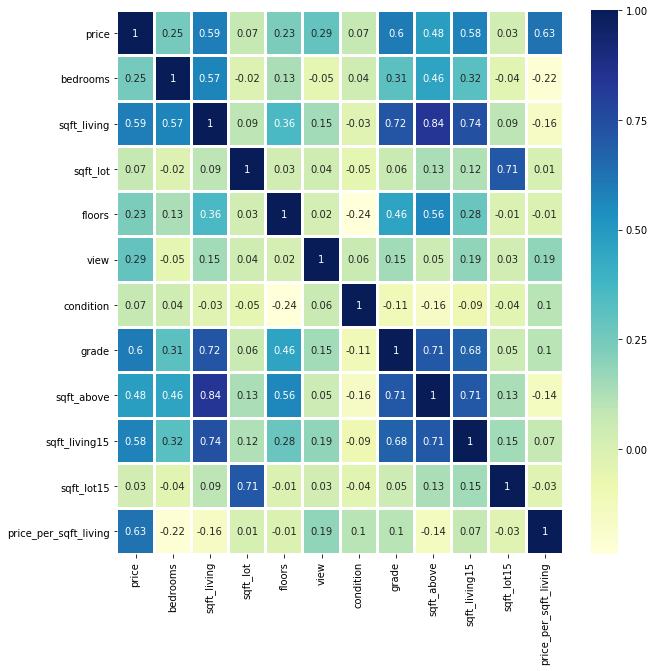

In [68]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data = corr1, annot = True, annot_kws = {"size": 10}, linewidth = 2, cmap="YlGnBu")

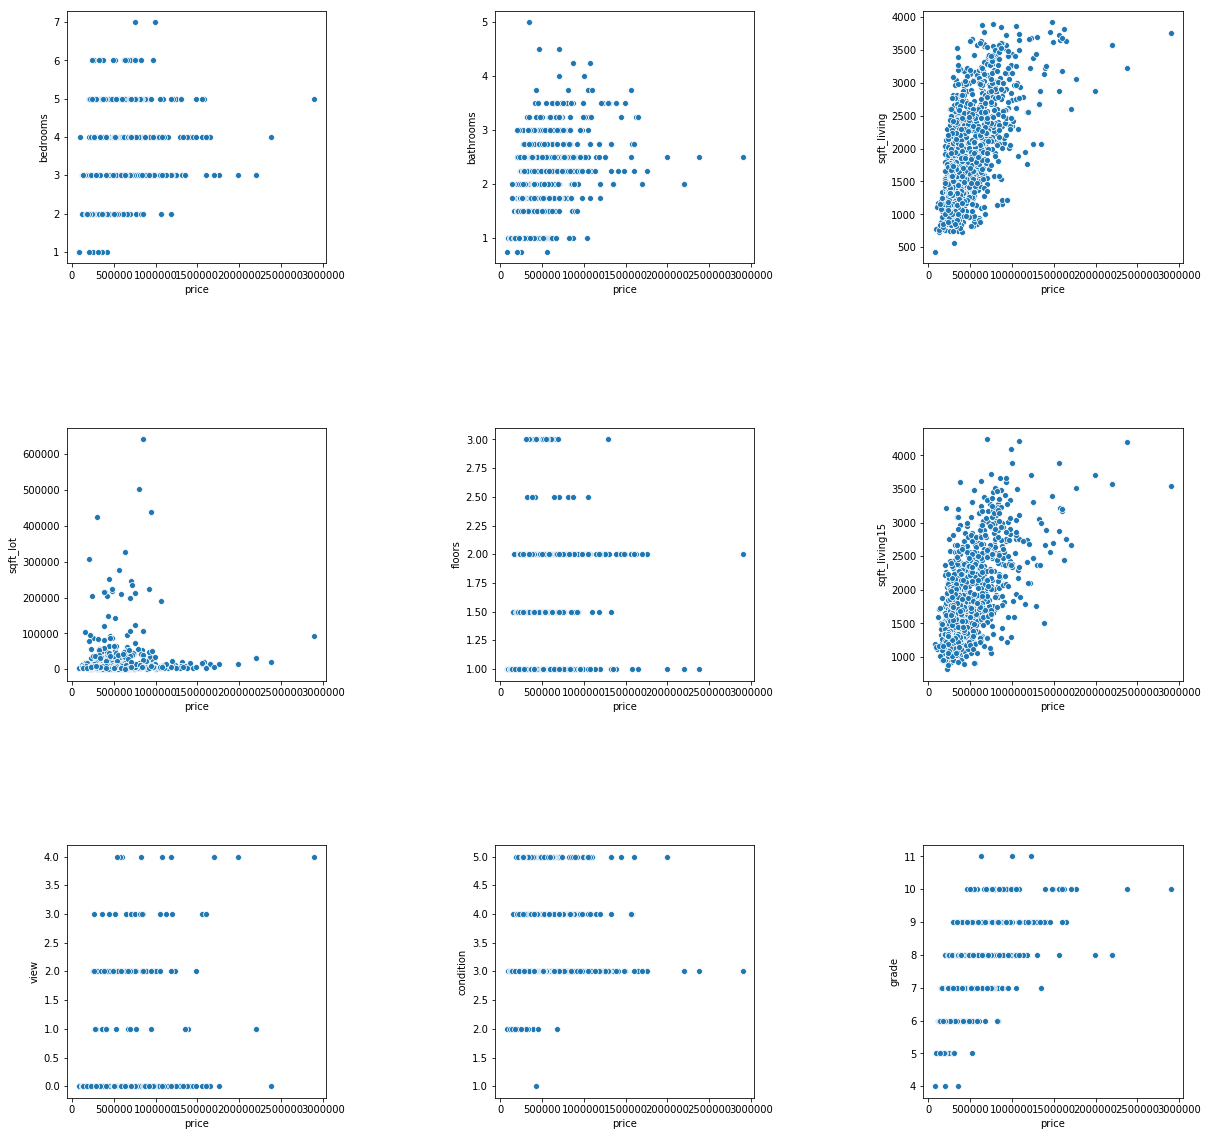

In [69]:
plt.figure(figsize=(20,20))

for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x="price", y=col, data= df_zip)
    plt.subplots_adjust(wspace=0.65, hspace=0.65)